In [330]:
import torch
# torchvision.datasets.FashionMNIST
import torchvision
# 修改数据集格式
from torchvision import transforms
# DataLoader
from torch.utils.data import DataLoader, Dataset
# nn块
from torch import nn
# PIL
from PIL import Image

In [331]:
# -----------参数-----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 64
lr = 3e-2
num_epochs=10
shape = (300, 400)

cuda


In [332]:
# 内容图像
content_img = Image.open('/home/lab/Desktop/2.png')
# 风格图像
style_img = Image.open('/home/lab/Desktop/1.png')

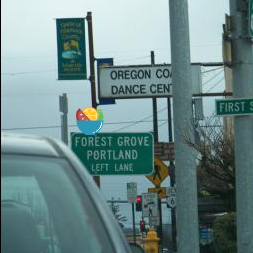

In [333]:
content_img

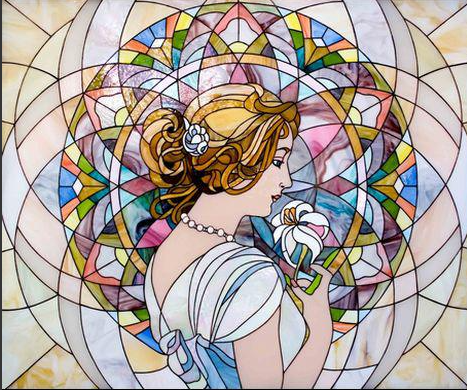

In [334]:
style_img

In [335]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

trans = [
    transforms.Resize(shape),  # 尺寸
    transforms.ToTensor(),          # Tensor化
    torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std),   # 归一化
]
# 转化列表为torchvision.transforms.transforms.Compose对象, 这样就能写 transform=trans
trans = transforms.Compose(trans)

In [336]:
context_X = trans(content_img).unsqueeze(0)
style_X = trans(style_img).unsqueeze(0)

In [337]:
# -----------参数-----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 64
lr = 3e-1
num_epochs = 500
shape = (300, 400)


cuda


In [338]:
# 风格层，内容层
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

# 预先训练好的网络
pretrained_net = torchvision.models.vgg19(weights='DEFAULT',progress=True)
features_net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)]).to(device)


def extract_features(X):
    X = X.to(device)
    contents_Y = []
    styles_Y = []
    for i in range(len(features_net)):
        X = features_net[i](X)
        if i in content_layers:
            contents_Y.append(X)
        if i in style_layers:
            styles_Y.append(X)
    return contents_Y, styles_Y

In [339]:
contents_Y, _ = extract_features(context_X)
_, styles_Y = extract_features(style_X)

In [340]:
# 该合成图像是风格迁移过程中唯一需要更新的变量，即**风格迁移所需迭代的模型参数**。
class SynthesizedImage(nn.Module):
    def __init__(self):
        super(SynthesizedImage, self).__init__()
        self.weight = nn.Parameter(torch.rand(context_X.shape))

    def forward(self):
        return self.weight

net = SynthesizedImage().to(device)

In [346]:
# 参数初始化
net.weight.data.copy_(context_X.data)
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [347]:
def content_loss(Y_hat, Y):
    Y = Y.to(device)
    # 我们从动态计算梯度的树中分离目标：
    # 这是一个规定的值，而不是一个变量。
    return torch.square(Y_hat - Y.detach()).mean()


def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)


def style_loss(Y_hat, Y):
    Y = Y.to(device)
    return torch.square(gram(Y_hat) - gram(Y.detach())).mean()


def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())


def compute_loss(contents_Y_hat, styles_Y_hat, contents_Y, styles_Y, X):
    content_weight, style_weight, tv_weight = 50, 1e3, 10
    # 内容损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    # 风格损失
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y)]
    # 全变分损失
    tv_l = [tv_loss(X) * tv_weight]
    # 对所有损失求和
    l = sum(styles_l + contents_l + tv_l)
    return contents_l, styles_l, tv_l, l


In [356]:
# ---------训练
for epoch in range(num_epochs):
    X = net()

    # Backpropagation
    optimizer.zero_grad()
    # 该批的推断结果
    contents_Y_hat, styles_Y_hat = extract_features(X)
    contents_l, styles_l, tv_l, train_loss = compute_loss(
        contents_Y_hat, styles_Y_hat, contents_Y, styles_Y, X)

    train_loss.backward()
    optimizer.step()

    # --------打印进度
    print(f'epoch {epoch + 1}, loss: ', train_loss.item() )


epoch 1, loss:  5.8812127113342285
epoch 2, loss:  5.8810038566589355
epoch 3, loss:  5.880969047546387
epoch 4, loss:  5.880747318267822
epoch 5, loss:  5.8806939125061035
epoch 6, loss:  5.880489349365234
epoch 7, loss:  5.88039493560791
epoch 8, loss:  5.880250930786133
epoch 9, loss:  5.880169868469238
epoch 10, loss:  5.880064010620117
epoch 11, loss:  5.879993438720703
epoch 12, loss:  5.879918575286865
epoch 13, loss:  5.879868507385254
epoch 14, loss:  5.879813194274902
epoch 15, loss:  5.879773139953613
epoch 16, loss:  5.879724502563477
epoch 17, loss:  5.879691123962402
epoch 18, loss:  5.879651069641113
epoch 19, loss:  5.879627227783203
epoch 20, loss:  5.879599094390869
epoch 21, loss:  5.879580020904541
epoch 22, loss:  5.87956428527832
epoch 23, loss:  5.879556655883789
epoch 24, loss:  5.879558563232422
epoch 25, loss:  5.879567623138428
epoch 26, loss:  5.8796257972717285
epoch 27, loss:  5.879662990570068
epoch 28, loss:  5.879729747772217
epoch 29, loss:  5.87976598

In [349]:
def postprocess(img):
    # (1,3,300,400) 变成 (3,300,400)
    img = img[0].to('cpu')
    # 因为与（1,3）乘法的广播运算需要， 需要变成（300,400,3）
    img = img.permute(1, 2, 0) * rgb_std + rgb_mean
    # 限定[0.0,1.0]之间
    img = torch.clamp(img, 0, 1)
    # 再转回来
    return transforms.ToPILImage()(img.permute(2, 0, 1))

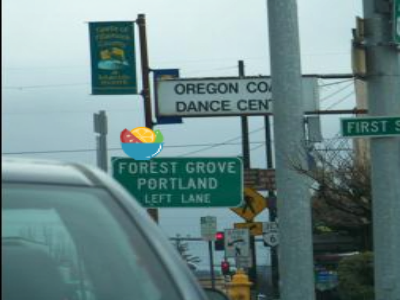

In [350]:
X = net()
out = postprocess(X)
out

# 风格迁移
这里我们需要两张输入图像：一张是*内容图像*，另一张是*风格图像*。

最终输出的合成图像应用了风格图像的风格，同时保留了内容图像中物体主体的形状。

## 方法

- 首先，我们初始化**合成图像**，例如将其初始化为内容图像。
  
  该合成图像是风格迁移过程中唯一需要更新的变量，即**风格迁移所需迭代的模型参数**。

- 然后，我们选择一个**预训练的卷积神经网络**来抽取图像的特征，其中的模型参数在训练中**无须更新**。

  这个深度卷积神经网络凭借**多个层逐级抽取图像的特征**，我们可以选择其中某些层的输出作为内容特征或风格特征。


  一般来说，越靠近输入层，越容易抽取图像的细节信息；越靠近输出层，则越容易抽取图像的全局信息。
  内容层需要避免合成图像过多保留内容图像的细节。
  所以， 靠近输出的层，作为*内容层*，来输出图像的内容特征。
  
  选择不同层的输出来匹配局部和全局的风格，这些图层也称为*风格层*。

  实验中，我们选择Vgg19第四卷积块的最后一个卷积层作为内容层，选择每个卷积块的第一个卷积层作为风格层。


风格迁移常用的损失函数由3部分组成: 内容损失、风格损失和全变分损失。
- *内容损失*: 使合成图像与内容图像在内容特征上接近；
  
  均方误差。

- *风格损失*: 使合成图像与风格图像在风格特征上接近；

  均方误差格拉姆Gram矩阵  

- *全变分损失*: 则有助于减少合成图像中的噪点。

  假设$x_{i, j}$表示坐标$(i, j)$处的像素值，降低全变分损失

  $$\sum_{i, j} \left|x_{i, j} - x_{i+1, j}\right| + \left|x_{i, j} - x_{i, j+1}\right| \\ 
  =\sum_{i, j} \left|x_{i, j} - x_{i+1, j}\right| + \sum_{i, j} \left|x_{i, j} - x_{i, j+1}\right|$$


  能够尽可能使邻近的像素值相似。

- 最后，当模型训练结束时，我们输出风格迁移的模型参数，即得到最终的合成图像。





## [**预处理和后处理**]

下面，定义图像的预处理函数和后处理函数。
预处理函数`preprocess`对输入图像在RGB三个通道分别做标准化，并将结果变换成卷积神经网络接受的输入格式。
后处理函数`postprocess`则将输出图像中的像素值还原回标准化之前的值。
由于图像打印函数要求每个像素的浮点数值在0到1之间，我们对小于0和大于1的值分别取0和1。


In [139]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    print('img.shape', img.shape)
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

## [**抽取图像特征**]

我们使用基于ImageNet数据集预训练的VGG-19模型来抽取图像特征 :cite:`Gatys.Ecker.Bethge.2016`。


为了抽取图像的内容特征和风格特征，我们可以选择VGG网络中某些层的输出。
一般来说，越靠近输入层，越容易抽取图像的细节信息；反之，则越容易抽取图像的全局信息。
为了避免合成图像过多保留内容图像的细节，我们选择VGG较靠近输出的层，即*内容层*，来输出图像的内容特征。
我们还从VGG中选择不同层的输出来匹配局部和全局的风格，这些图层也称为*风格层*。
正如 :numref:`sec_vgg`中所介绍的，VGG网络使用了5个卷积块。
实验中，我们选择第四卷积块的最后一个卷积层作为内容层，选择每个卷积块的第一个卷积层作为风格层。
这些层的索引可以通过打印`pretrained_net`实例获取。


In [125]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

使用VGG层抽取特征时，我们只需要用到从输入层到最靠近输出层的内容层或风格层之间的所有层。
下面构建一个新的网络`net`，它只保留需要用到的VGG的所有层。


In [126]:
net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])

给定输入`X`，如果我们简单地调用前向传播`net(X)`，只能获得最后一层的输出。
由于我们还需要中间层的输出，因此这里我们逐层计算，并保留内容层和风格层的输出。


In [127]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [128]:
preprocess(content_img, (300,400)).shape

torch.Size([1, 3, 300, 400])

下面定义两个函数：`get_contents`函数对内容图像抽取内容特征；
`get_styles`函数对风格图像抽取风格特征。
因为在训练时无须改变预训练的VGG的模型参数，所以我们可以在训练开始之前就提取出内容特征和风格特征。
由于合成图像是风格迁移所需迭代的模型参数，我们只能在训练过程中通过调用`extract_features`函数来抽取合成图像的内容特征和风格特征。


In [129]:
# 获取 内容图像 和 内容层输出
def get_contents(image_shape, device):
    # 内容图像
    content_X = preprocess(content_img, image_shape).to(device)
    # 内容图像取内容层输出
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y


# 获取 风格图像 和 风格层输出
def get_styles(image_shape, device):
    # 风格图像
    style_X = preprocess(style_img, image_shape).to(device)
    # 风格图像取风格层输出
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

## [**定义损失函数**]

下面我们来描述风格迁移的损失函数。
它由内容损失、风格损失和全变分损失3部分组成。

### 内容损失

与线性回归中的损失函数类似，内容损失通过平方误差函数衡量合成图像与内容图像在内容特征上的差异。
平方误差函数的两个输入均为`extract_features`函数计算所得到的内容层的输出。


In [130]:
def content_loss(Y_hat, Y):
    # 我们从动态计算梯度的树中分离目标：
    # 这是一个规定的值，而不是一个变量。
    return torch.square(Y_hat - Y.detach()).mean()

### 风格损失

风格损失与内容损失类似，也通过平方误差函数衡量合成图像与风格图像在风格上的差异。
为了表达风格层输出的风格，我们先通过`extract_features`函数计算风格层的输出。
假设该输出的样本数为1，通道数为$c$，高和宽分别为$h$和$w$，我们可以将此输出转换为矩阵$\mathbf{X}$，其有$c$行和$hw$列。
这个矩阵可以被看作是由$c$个长度为$hw$的向量$\mathbf{x}_1, \ldots, \mathbf{x}_c$组合而成的。其中向量$\mathbf{x}_i$代表了通道$i$上的风格特征。

在这些向量的*格拉姆矩阵*$\mathbf{X}\mathbf{X}^\top \in \mathbb{R}^{c \times c}$中，$i$行$j$列的元素$x_{ij}$即向量$\mathbf{x}_i$和$\mathbf{x}_j$的内积。它表达了通道$i$和通道$j$上风格特征的相关性。我们用这样的格拉姆矩阵来表达风格层输出的风格。
需要注意的是，当$hw$的值较大时，格拉姆矩阵中的元素容易出现较大的值。
此外，格拉姆矩阵的高和宽皆为通道数$c$。
为了让风格损失不受这些值的大小影响，下面定义的`gram`函数将格拉姆矩阵除以了矩阵中元素的个数，即$chw$。


In [131]:
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

自然地，风格损失的平方误差函数的两个格拉姆矩阵输入分别基于合成图像与风格图像的风格层输出。这里假设基于风格图像的格拉姆矩阵`gram_Y`已经预先计算好了。


In [132]:
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

### 全变分损失

有时候，我们学到的合成图像里面有大量高频噪点，即有特别亮或者特别暗的颗粒像素。
一种常见的去噪方法是*全变分去噪*（total variation denoising）：
假设$x_{i, j}$表示坐标$(i, j)$处的像素值，降低全变分损失

$$\sum_{i, j} \left|x_{i, j} - x_{i+1, j}\right| + \left|x_{i, j} - x_{i, j+1}\right|$$
$$\sum_{i, j} \left|x_{i, j} - x_{i+1, j}\right| + \sum_{i, j} \left|x_{i, j} - x_{i, j+1}\right|$$


能够尽可能使邻近的像素值相似。


In [133]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

### 损失函数

[**风格转移的损失函数是内容损失、风格损失和总变化损失的加权和**]。
通过调节这些权重超参数，我们可以权衡合成图像在保留内容、迁移风格以及去噪三方面的相对重要性。


In [134]:
content_weight, style_weight, tv_weight = 50, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、风格损失和全变分损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和

    l = sum(styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

## [**初始化合成图像**]

在风格迁移中，合成的图像是训练期间唯一需要更新的变量。因此，我们可以定义一个简单的模型`SynthesizedImage`，并将合成的图像视为模型参数。模型的前向传播只需返回模型参数即可。


In [135]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

下面，我们定义`get_inits`函数。该函数创建了合成图像的模型实例，并将其初始化为图像`X`。风格图像在各个风格层的格拉姆矩阵`styles_Y_gram`将在训练前预先计算好。


In [136]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

## [**训练模型**]

在训练模型进行风格迁移时，我们不断抽取合成图像的内容特征和风格特征，然后计算损失函数。下面定义了训练循环。


In [137]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

现在我们[**训练模型**]：
首先将内容图像和风格图像的高和宽分别调整为300和450像素，用内容图像来初始化合成图像。


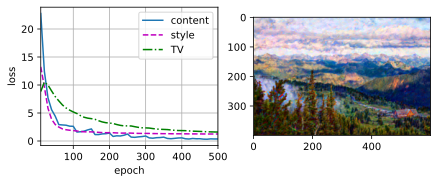

In [140]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
device, image_shape = 'cuda', (400, 600)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

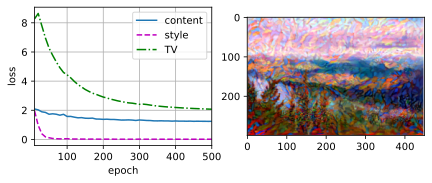

In [ ]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
device, image_shape = 'cuda', (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

我们可以看到，合成图像保留了内容图像的风景和物体，并同时迁移了风格图像的色彩。例如，合成图像具有与风格图像中一样的色彩块，其中一些甚至具有画笔笔触的细微纹理。

## 小结

* 风格迁移常用的损失函数由3部分组成：（i）内容损失使合成图像与内容图像在内容特征上接近；（ii）风格损失令合成图像与风格图像在风格特征上接近；（iii）全变分损失则有助于减少合成图像中的噪点。
* 我们可以通过预训练的卷积神经网络来抽取图像的特征，并通过最小化损失函数来不断更新合成图像来作为模型参数。
* 我们使用格拉姆矩阵表达风格层输出的风格。

[Discussions](https://discuss.d2l.ai/t/3300)
